# Computational methods for Bayesian inference

Joshua French

To open this information in an interactive Colab notebook, click the
Colab graphic below.

<a href="https://colab.research.google.com/github/jfrench/BayesianStatistics/blob/master/lectures/Math7393-03b-Computational-methods-for-Bayesian-inference-Deterministic.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg">
</a>

------------------------------------------------------------------------

In [1]:
# check to see if necessary packages are installed
if(!require(mvtnorm, quietly = TRUE)) {
  # install and load packages if necessary
  install.packages("mvtnorm", repos = "https://cran.rstudio.com/")
  library(mvtnorm)
}
if(!require(cubature, quietly = TRUE)) {
  install.packages("cubature", repos = "https://cran.rstudio.com/")
  library(cubature)
}

# Deterministic methods

## MAP estimation

The *maximum a posteriori* estimator, $\hat{\theta}_{\textrm{MAP}}$,
summarizes the posterior with the parameter values that maximize the
posterior distribution, i.e.,
$$\hat{\theta}_{\textrm{MAP}} = \text{argmax}_{\theta} \ln p(\theta | y) = \text{argmax}_{\theta} \ln p(y | \theta ) + \ln p(\theta).$$

**MAP Example 1**

*Data distribution*

$y_1, \ldots, y_n \mid \theta \stackrel{i.i.d.}{\sim} \text{Poisson}(\theta)$

pdf:

<br>  
<br>

*Prior distribution*

$\theta \sim \text{Exp}(1)$

pdf:

<br>  
<br>

*Posterior distribution*

pdf:

<br>  
<br>

$\ln p(\theta \mid y) \propto \text{const} - (n - 1) \theta + \sum y_i \ln(\theta)$

Let’s start by generating some data.

In [2]:
# Generate some synthetic data from a Poisson(0.5)
set.seed(8)
y <- rpois(10, lambda = 0.5)

Now, we create a function to compute the log of the unnormalized
posterior.

In [3]:
# create function for log unnormalized posterior
# theta = estimand
# sumy = sum(y)
# n = sample size
lup <- function(theta, sumy, n) {
  -(n + 1) * theta + sumy * log(theta)
}

We now use the `optimize` function to optimize the objective function,
`lup`, between 0 and 1.

-   We start our search `interval` just above 0 to avoid numerical
    issues.
-   We set `maximum` to `TRUE` to find the parameter that maximizes the
    objection function, `lup`.

In [4]:
(map <- optimize(
  f = lup, interval = c(0.0001, 10),
  maximum = TRUE,
  sumy = sum(y), n = length(y)
))
# maximum occurs at theta = 0.64

$maximum 
 0.636370455717938 
 $objective 
 -10.1638958666033

We plot our results to double-check accuracy.

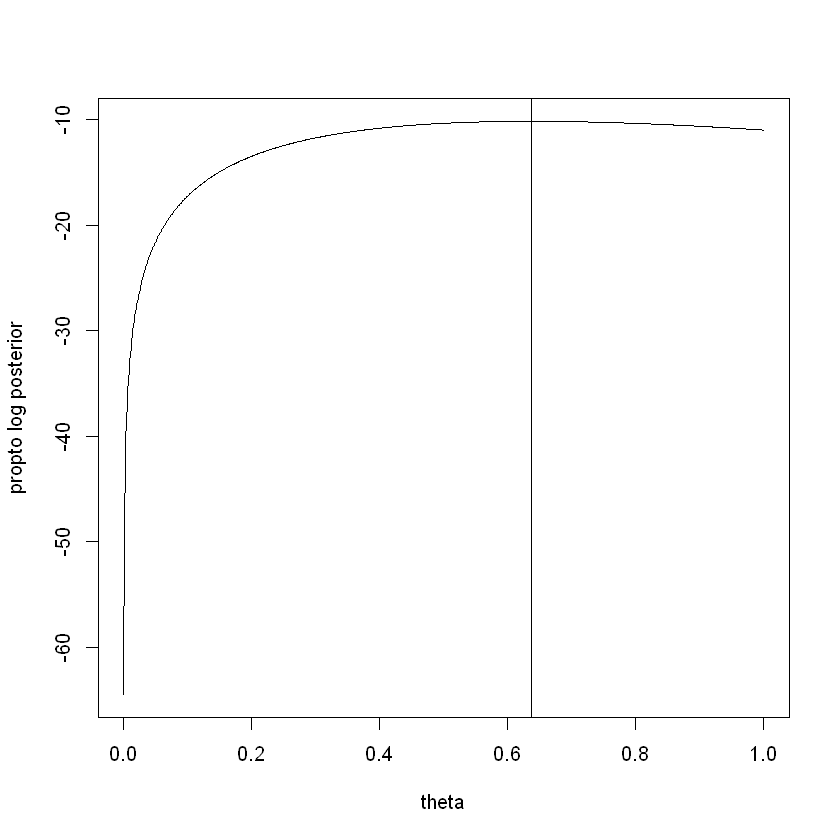

In [5]:
# domain of plot
mytheta <- seq(0.0001, 1, length = 1000)
# plot function
plot(mytheta, lup(mytheta, sumy = sum(y), n = length(y)),
  type = "l",
  xlab = "theta", ylab = "propto log posterior"
)
# show maximum
abline(v = map$maximum)

We now use a different approach that doesn’t simplify ahead of time.
Note that

$$
\begin{aligned}
\ln [p(y\mid \theta)p(\theta)] &= \ln p(y\mid \theta) + \ln p(\theta) \\
&= \ln \left(\prod_{i=1}^n p(y_i\mid\theta)\right) + \ln p(\theta) \\
&= \sum_{i=1}^n \ln p(y_i\mid\theta) + \ln p(\theta).
\end{aligned}
$$

In [6]:
# second version of log unnormalized posterior
lup2 <- function(theta, y) {
  sum(dpois(y, lambda = theta, log = TRUE)) +
    dexp(theta, rate = 1, log = TRUE)
}

# same results!
optimize(
  f = lup2, interval = c(0.0001, 10), maximum = TRUE,
  y = y
)

$maximum 
 0.636370455717878 
 $objective 
 -10.8570430471633

**MAP Example 2 (2 parameter)**

*Data distribution*

$y_1, ..., y_n \mid \mu, \sigma^2 \stackrel{i.i.d.}{\sim} N(\mu, \sigma^2)$

pdf:

<br>  
<br>

*Prior distribution*

$\mu \sim U(10, 15)$

pdf:

<br>  
<br>

$\sigma^2 \sim N(0.5, 0.25) I_{(0,\infty)}(\sigma^2)$

pdf:

<br>  
<br>

This is essentially a truncated normal with a different scaling
constant.

We start by generating some fake data.

In [7]:
# Generate some synthetic data
# Normal with mean 11 and sd = 0.47
set.seed(7)
y <- rnorm(10, mean = 11, sd = 0.47)

We program the negative log of the unnormalized posterior density.

-   The function takes $\theta = (\mu, \sigma^2)$.
-   We *don’t* constrain $\mu$ to be between 10 and 15 and $\sigma^2$ to
    be positive only because we will do this constraint in our
    optimization.
-   We multiply the log posterior by -1 so that instead of trying to
    maximize the log unnormalized posterior, we minimize the negative
    log unnormalized posterior.

In [8]:
nlup <- function(theta, y) {
  mu <- theta[1]
  sigma <- sqrt(theta[2])
  obj <- sum(dnorm(y, mean = mu, sd = sigma, log = TRUE)) +
    dunif(mu, 10, 15, log = TRUE) +
    dnorm(sigma^2, mean = 0.5, sd = 0.5, log = TRUE)
  -obj
}

We now use the `optim` function to perform multi-dimensional
optimization.

-   `par`: vector of starting values
-   `f`: function to MINIMIZE. The first argument must be the argument
    you want to optimize over.
-   `lower`: the constraints on the lower bound
-   `upper`: the constraints on the upper bound
-   `method`: the optimization method. `"L-BFGS-B"` allows use to
    specify constraints.
-   `control`: list of optional tuning parameters.
-   The remaining arguments are the arguments that must be supplied to
    `f`.

In [9]:
optim(
  par = c(12.5, 1),
  f = nlup,
  lower = c(10.0001, 0.05),
  upper = c(14.9999, 2),
  method = "L-BFGS-B",
  y = y
)

$par 
 
 11.0488685605075 0.333794555842658 
 
 $value 
 10.3717733516641 
 $counts 
 function 16 gradient 16 
 
 $convergence 
 0 
 $message 
 'CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH'

`nlminb` is an alternative optimizer that is more robust (from my
personal experience.)

-   The arguments are self-explanatory.

In [10]:
(map <- nlminb(
  start = c(12.5, 1),
  objective = nlup,
  lower = c(10.0001, 0.0001),
  upper = c(14.9999, 2),
  y = y
))

$par 
 
 11.0488677881752 0.333793546875569 
 
 $objective 
 10.3717733516113 
 $convergence 
 0 
 $iterations 
 11 
 $evaluations 
 function 16 gradient 30 
 
 $message 
 'relative convergence (4)'

Let’s plot our results.

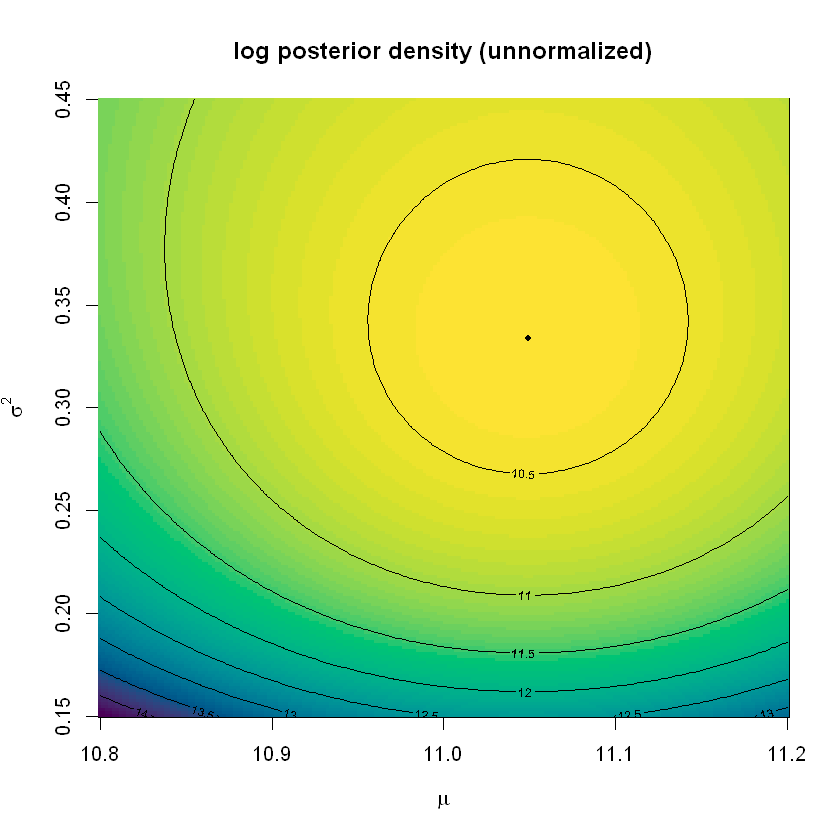

In [11]:
# create sequence of values for mu and sigmasq
mymu <- seq(10.8, 11.2, length = 200)
mysigmasq <- seq(0.15, 0.45, length = 200)
# create grid
mytheta <- expand.grid(mymu, mysigmasq)
# for each row of mytheta, plug it into nlup function
z <- apply(mytheta, 1, function(theta) {
  nlup(theta, y = y)
})
# convert z to matrix for plotting
zmat <- matrix(z, nrow = length(mymu))
# create heat map of objective surface
image(mymu, mysigmasq, zmat,
  col = hcl.colors(64, rev = TRUE),
  xlab = expression(mu), ylab = expression(sigma^2)
)
# add contours
contour(mymu, mysigmasq, zmat, add = TRUE)
# place point for posterior mode
points(map$par[1], map$par[2], pch = 20)
title("log posterior density (unnormalized)")

## Cubature methods

Cubature methods approximate an integral by evaluating a function at a
finite number of points and aggregating the results. (We won’t discuss
specifics.)

**Cubature method example (Beta-Binomial)**

*Data distribution*

$y \mid \theta \sim \text{Bin}(n, \theta)$.

Let’s assume $n=980$ and $y=437$.

*Prior distribution*

$\theta \sim \text{Beta}(\alpha, \beta)$.

Let’s assume $\alpha=\beta=1$.

*Posterior distribution*

$\theta \mid y \sim \text{Beta}(y + \alpha, n - y + \beta)$.

This has posterior mean $\frac{y + \alpha}{n + \alpha + \beta}$.

Based on our assumptions above,
$\theta \mid y \sim \text{Beta}(438, 544)$.

*Posterior predictive distribution*

$P(\tilde{y} = 1 \mid y) = \frac{y + \alpha}{n + \alpha + \beta}$.

Based on previous assumptions,
$P(\tilde{y} = 1 \mid y) = 448/(438 + 544) \approx 0.446$.

Let’s use the cubature method to approximate some of these.

We start by defining the posterior density with a generic normalizing
constant.

In [12]:
# unnormalized posterior
dpost <- function(theta, const = 1) {
  dbinom(x = 437, size = 980, prob = theta) *
    dbeta(theta, shape1 = 1, shape2 = 1) /
    const
}

We determine the normalizing constant.

In [13]:
(nconst <- integrate(dpost, lower = 0, upper = 1)$value)

0.00101936799151945

Now, we define the function $\theta p(\theta \mid y)$.

In [14]:
# theta * posterior
mean_target <- function(theta, const) {
  theta * dpost(theta, const)
}

We integrate $\theta p(\theta \mid y)$ for $\theta \in [0, 1]$.

In [15]:
# compute posterior mean using cubature
integrate(mean_target, lower = 0, upper = 1, const = nconst)

0.4460285 with absolute error < 8.3e-05

Next, we define the function that evaluates
$P(\tilde{y} = 1 \mid \theta) p(\theta \mid y)$.

In [16]:
# pytilde * ptarget
pytilde_target <- function(theta, const) {
  dbinom(x = 1, size = 1, prob = theta) *
    dpost(theta, const)
}

Lastly, we integrate that function to compute
$P(\tilde{y} = 1 \mid \theta)$.

In [17]:
# posterior predictive probability
integrate(pytilde_target, lower = 0, upper = 1, const = nconst)

0.4460285 with absolute error < 8.3e-05

## Bayesian CLT for $N(\mu,\sigma^2)$

**Example 1**

*Data distribution*

$y_1, ..., y_n \mid \theta \stackrel{i.i.d}{\sim} \text{Poisson}(\theta)$

*Prior distribution*

$\theta \sim \text{Exp}(1)$

*Negative Hessian,* $-H(\theta)$

$-\frac{d^2}{d\theta^2} \ln p(y \mid \theta) = \frac{\sum y_i}{\theta^2}$.

*Approximate posterior distribution*

For a large sample of data,
$p(\theta \mid y) \approx N(\hat{\theta}, \hat{\theta}^2/\sum y_i)$.

We start be generating a small data set.

In [18]:
# Generate some synthetic data
# Poisson with mean of 0.5
set.seed(3) # for reproducibility
y <- rpois(10, lambda = 0.5)

We now define the posterior density with a generic normalizing constant.

In [19]:
dpost <- function(theta, y, const = 1) {
  log_pdata <- sum(dpois(y, lambda = theta, log = TRUE))
  log_pprior <- dexp(theta, rate = 1, log = TRUE)
  exp(log_pdata + log_pprior - log(const))
}

Let’s try plotting this function to help us determine what we should be
maximizing over.

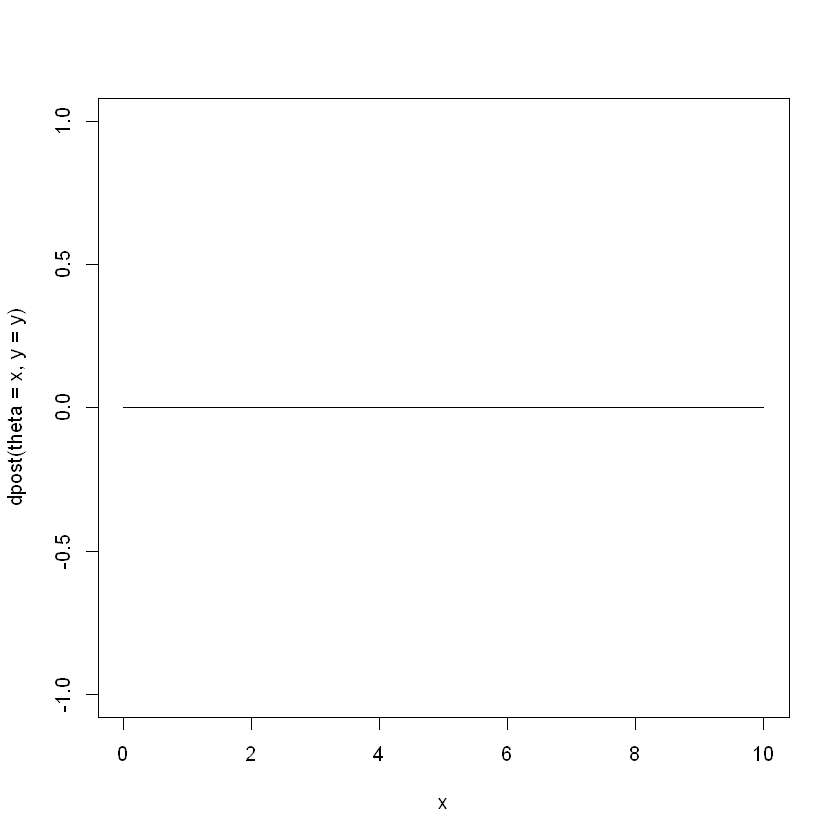

In [20]:
# plot dpost to determine what to maximize over
x <- seq(0.001, 10, len = 1000)
plot(x, dpost(theta = x, y = y), type = "l", )

We’re getting weird results because `dpost` is trying to evaluate
`dpois` with a vector `y` and a vector `theta` whose dimensions are
incompatible.

We want to evaluate `dpois(y, ...)` for *each* value of `theta`.

We can use the `Vectorize` function to vectorize a function with respect
to a certain argument.

In [21]:
vdpost <- Vectorize(dpost, vectorize.args = "theta")

Now, we try our plot again.

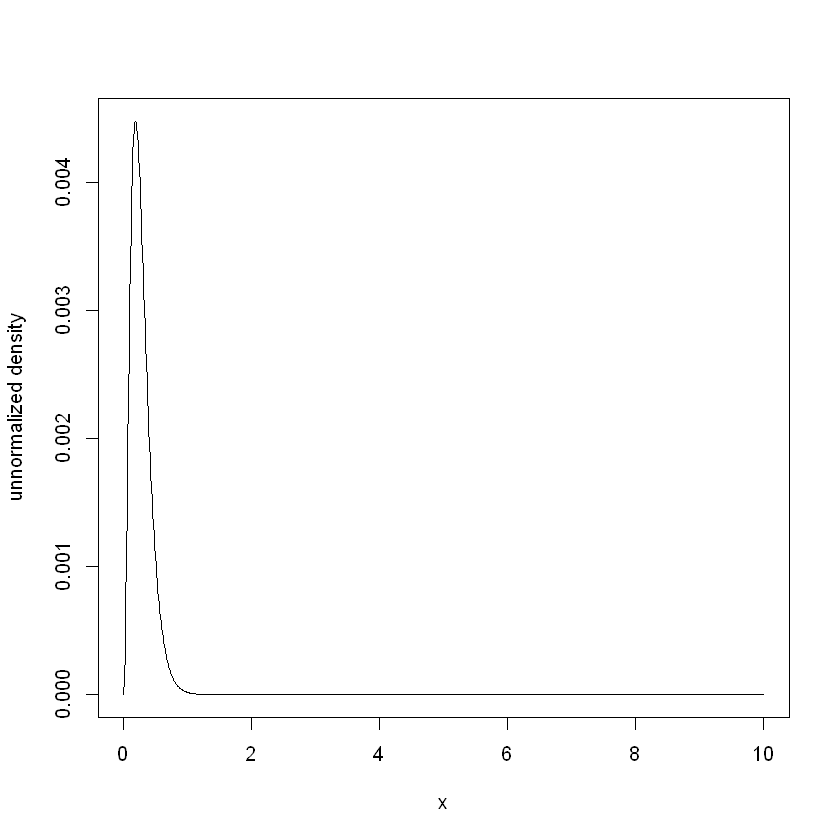

In [22]:
# plot vectorized dpost to determine what to maximize over
plot(x, vdpost(theta = x, y = y), type = "l",
     ylab = "unnormalized density")

We can determine $\hat{\theta}_{\text{MAP}}$ over the interval $[0, 2]$.

In [23]:
# determine MAP
(map <- optimize(vdpost, interval = c(0, 2), y = y, maximum = TRUE)$maximum)

0.18182479314491

$\hat{\theta}_{MAP}\approx 0.18$. Thus, our posterior approximation is
$N(0.18, 0.18^2/\sum y_i)$.

Let’s plot the “truth” versus the approximation. In order to do that, we
need to figure out the “true” distribution. We do this to illustrate the
effectiveness of the approximation. We wouldn’t normally do this.

We find our normalizing constant.

In [24]:
# determine normalizing constant
(nconst <- integrate(f = vdpost, lower = 0, upper = 10, y = y)$value)

0.00150262960180409

We double-check that the posterior is proper!

In [25]:
integrate(vdpost, lower = 0, upper = 10, y = y, const = nconst)

1 with absolute error < 5.4e-08

We define a function to evaluate our approximate posterior distribution.

In [26]:
# normal approximation posterior
dpapprox <- function(theta, y, thetahat) {
  dnorm(theta, mean = thetahat, sd = sqrt(thetahat^2 / sum(y)))
}

Now, we plot the “true” posterior density versus the approximate
posterior density.

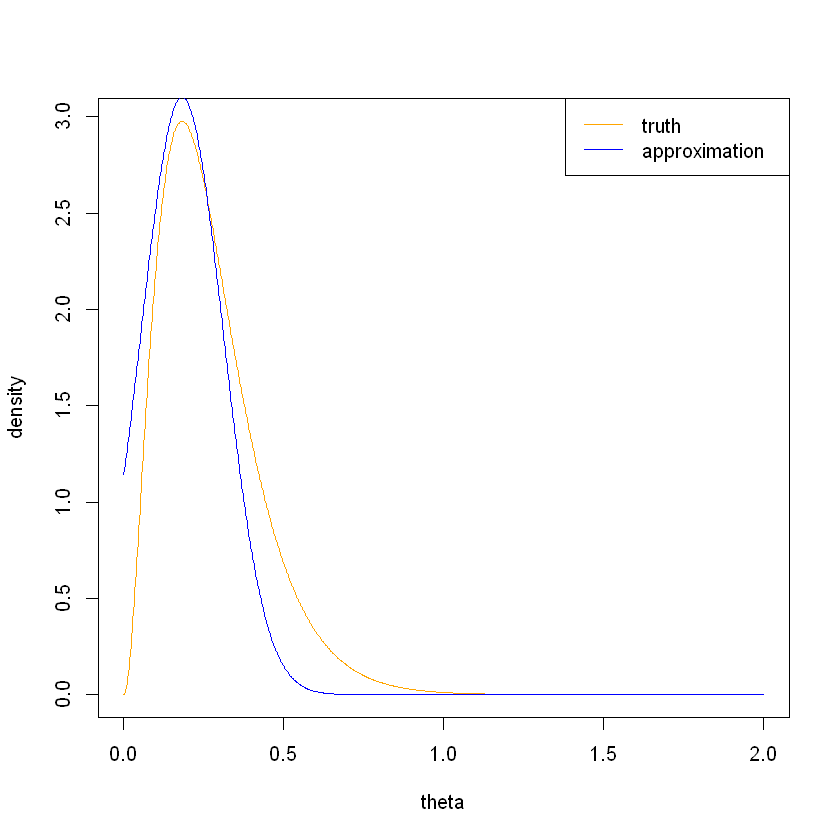

In [27]:
# range of theta values
theta <- seq(0, 2, length = 1000)
# plot true density
plot(theta, vdpost(theta, y, nconst),
     ylab = "density", type = "l", col = "orange")
# plot normal approximation
lines(theta, dpapprox(theta, y, thetahat = map),
      col = "blue")
legend("topright",
  legend = c("truth", "approximation"),
  col = c("orange", "blue"), lty = 1
)

Our approximation isn’t great because our sample size is small. Let’s
perform the same approximation with a larger sample size.

We generate 100 i.i.d. observations from a Poisson(0.5) distribution.

In [28]:
set.seed(3) # for reproducibility
y100 <- rpois(100, lambda = 0.5)

We once again plot the unnormalized posterior to determine the range of
`theta` to optimize over.

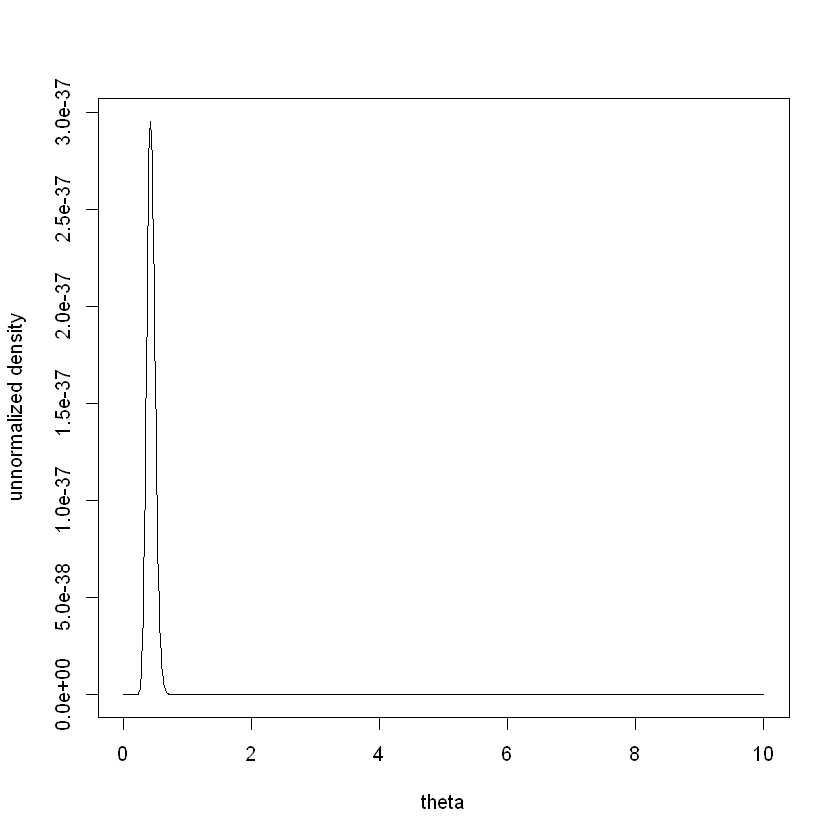

In [29]:
plot(x, vdpost(theta = x, y = y100),
  type = "l",
  xlab = "theta", ylab = "unnormalized density"
)

We determine $\hat{\theta}_{\text{MAP}}$.

In [30]:
(map100 <- optimize(vdpost, interval = c(0, 2),
                    y = y100, maximum = TRUE)$maximum)

0.415846179773904

$\hat{\theta}_{\text{MAP}}\approx 0.42$. Thus, our posterior
approximation is $N(0.42, 0.42^2/\sum y_i)$.

Let’s plot the “truth” versus the approximation.

We compute the normalizing constant for our posterior.

In [31]:
# determine normalizing constant
(nconst100 <- integrate(f = vdpost, lower = 0, upper = 10, y = y100)$value)

3.54430384290875e-38

We double-check that posterior is proper.

In [32]:
integrate(vdpost, lower = 0, upper = 10, y = y100, const = nconst100)

1.345944 with absolute error < 6.6e-08

We have a big issue! Our (numerical) integral is no longer integrating
to 1. Why? Computational underflow!

When we evaluate our unnormalized posterior, all of the values are close
to zero.

We need to shift the unnormalized posterior vertically so that some of
the values are higher. I choose to make the largest value 1 by using the
trick below.

-   Evaluate the log unnormalized density over the range of the
    $\theta$.
-   Subtract the LARGEST number you get from the log unnormalized
    density.
-   Convert back to the original scale using $\exp$.

In [33]:
lqpost <- function(theta, y) {
  log_pdata <- sum(dpois(y, lambda = theta, log = TRUE))
  log_pprior <- dexp(theta, rate = 1, log = TRUE)
  log_pdata + log_pprior
}
vlqpost <- Vectorize(lqpost, vectorize.args = "theta")
range(vlqpost(x, y = y100))

-918.548921466278 -84.1128795628471

We create a “robust” version of the unnormalized density.

In [34]:
qpost_robust <- function(theta, y) {
  log_pdata <- sum(dpois(y, lambda = theta, log = TRUE))
  log_pprior <- dexp(theta, rate = 1, log = TRUE)
  exp(log_pdata + log_pprior + 84.11288)
}
# vectorize
vqpost_robust <- Vectorize(qpost_robust,
  vectorize.args = "theta"
)

The new unnormalized density has a maximum of 1.

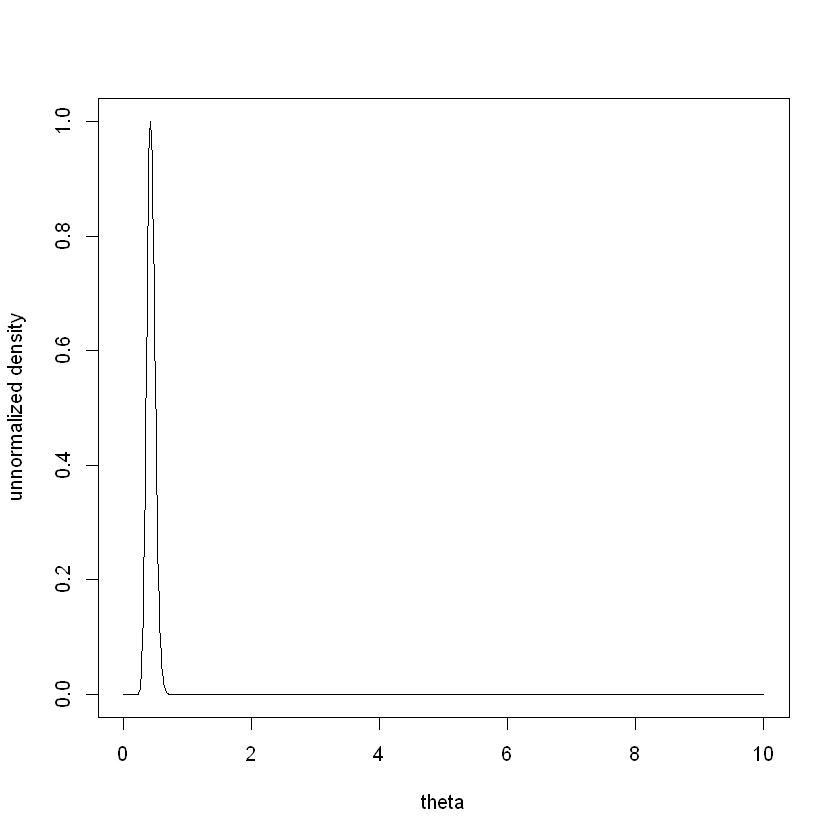

In [35]:
plot(x, vqpost_robust(x, y = y100),
  xlab = "theta", ylab = "unnormalized density",
  type = "l"
)

Now, we determine the normalizing constant of our robust unnormalized
density.

In [36]:
# determine normalizing constant
(nconst100 <- integrate(f = vqpost_robust, lower = 0, upper = 10, y = y100)$value)

0.16155394029371

We now create a robust version of our posterior density.

In [37]:
# posterior density function
dpost_robust <- function(theta, y, const) {
  qpost_robust(theta, y) / const
}
# vectorized version of dpost_robust for integrate function
vdpost_robust <- Vectorize(dpost_robust,
  vectorize.args = "theta"
)

We double-check that our robust posterior density is proper.

In [38]:
integrate(vdpost_robust,
  lower = 0, upper = 10,
  y = y100, const = nconst100
)

1 with absolute error < 4.9e-08

Finally, we create a plots to compare our true density versus our normal
approximation.

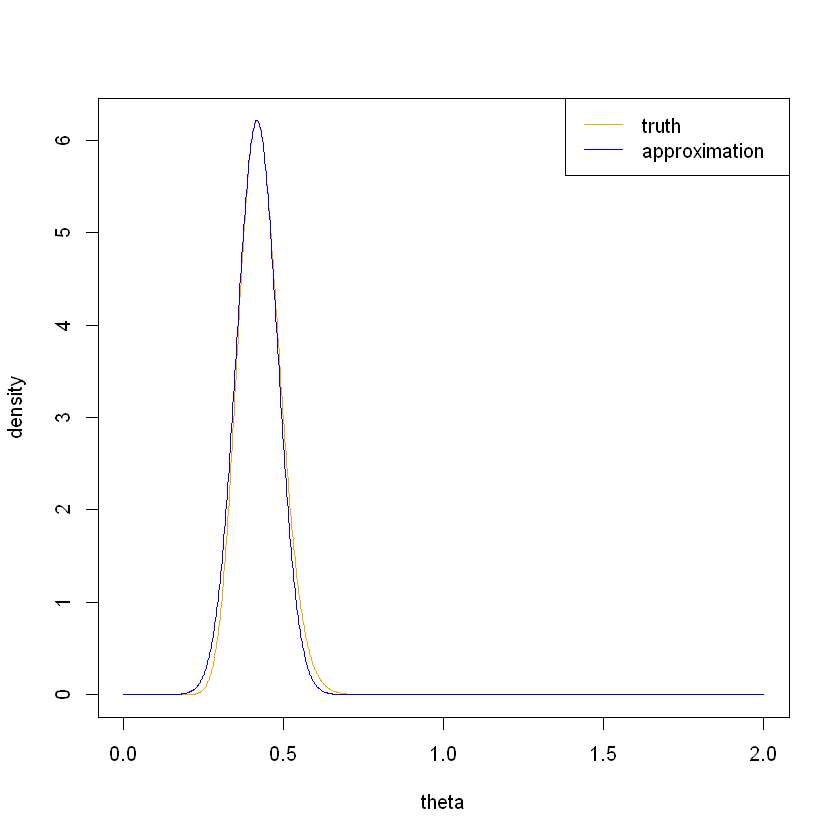

In [39]:
# plot true density
plot(theta, vdpost_robust(theta, y100, nconst100),
     ylab = "density", type = "l", col = "orange")
# plot normal approximation
lines(theta, dpapprox(theta, y100, thetahat = map100), col = "blue")
legend("topright",
  legend = c("truth", "approximation"),
  col = c("orange", "blue"), lty = 1
)

**Bayesian CLT Example (Two parameter)**

*Data distribution*

$y_1, y_2, \ldots, y_n | \mu, \sigma^2 \stackrel{i.i.d.}{\sim} N(\mu, \sigma^2)$

*Prior distribution*

$\mu \sim U(10, 15)$,
$p(\sigma^2) \propto N(0.5, 0.5^2) I_{(0, \infty)}(\sigma^2)$

*Posterior distribution (Bayesian CLT)*

Assuming $n$ is large, $\theta = (\mu, \sigma^2)$, and
$\hat{\theta} = \hat{\theta}_{MAP}$,
$\theta | y \sim N(\hat{\theta}, I(\hat{\theta})^{-1}).$

The data density is

$$
\begin{aligned}
p(y|\theta) &= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{1}{2\sigma^2}(y_i-\mu)^2\right) \\
 &= (2\pi)^{-n/2}\left(\sigma^2\right)^{-n/2}\exp\left(-\frac{1}{2\sigma^2}\sum_{i=1}^n(y_i-\mu)^2\right)
\end{aligned}
$$ and $$
\ln p(y|\theta) = \mathrm{const} - \frac{n}{2} \ln \left(\sigma^2\right) -\frac{1}{2\sigma^2}\sum_{i=1}^n(y_i-\mu)^2.
$$

The first partial derivatives of $\ln p(y|\theta)$ are
$$\frac{\partial}{\partial \mu} \ln p(y|\theta) = \frac{1}{\sigma^2}\sum_{i=1}^n(y_i-\mu)$$
and
$$\frac{\partial}{\partial \sigma^2} \ln p(y|\theta) = -\frac{n}{2\sigma^2} +\frac{1}{\left(2\sigma^2\right)^2}\sum_{i=1}^n(y_i-\mu)^2.$$

The second partial derivatives of $\ln p(y|\theta)$ are
$$\frac{\partial^2}{\partial \mu^2} \ln p(y|\theta) = -\frac{n}{\sigma^2}$$
and
$$\frac{\partial^2}{\partial \left(\sigma^2\right)^2} \ln p(y|\theta) = \frac{n}{2\left(\sigma^2\right)^2} -\frac{1}{\left(\sigma^2\right)^3}\sum_{i=1}^n(y_i-\mu)^2$$
and

$$\frac{\partial^2}{\partial \mu \partial \sigma^2} \ln p(y|\theta) = -\frac{1}{\left(\sigma^2\right)^2}\sum_{i=1}^n(y_i-\mu)$$

Thus, if $\hat{\theta} = (\hat{\mu}, \hat{\sigma}^2)$ is the MAP
estimate of $\theta = (\mu, \sigma^2)$, then the Bayesian CLT
approximation of the posterior is
$\theta | y \approx N(\hat{\theta}, I(\hat{\theta})^{-1})$, where

$$
I(\hat{\theta})^{-1} = \begin{bmatrix}
\frac{n}{\hat{\sigma}^2} & \frac{1}{\left(\hat{\sigma}^2\right)^2}\sum_{i=1}^n(y_i-\hat{\mu})\\
\frac{1}{\left(\hat{\sigma}^2\right)^2}\sum_{i=1}^n(y_i-\hat{\mu}) & -\frac{n}{2\left(\hat{\sigma}^2\right)^2} +\frac{1}{\left(\hat{\sigma}^2\right)^3}\sum_{i=1}^n(y_i-\hat{\mu})^2
\end{bmatrix}^{-1}.
$$

Let’s generate some data.

In [40]:
# Generate some synthetic data
# in practice, we just have some data
set.seed(7)
y <- rnorm(100, mean = 11, sd = 0.47)

Now we create functions related to the true posterior density. This
wouldn’t normally be needed, but we want to assess how good our
approximation is.

We create a density function with a built-in correction to address the
numerical underflow issue. The function takes:

-   `theta`: a vector parameterized as $\theta = (\mu, \sigma^2)$.
-   `y`: data vector.
-   `const`: the normalizing constant, which we don’t yet know. We use
    1.

In [41]:
dpost <- function(theta, y, const = 1) {
  mu <- theta[1]
  sigma <- sqrt(theta[2])
  log_pdata <- sum(dnorm(y, mean = mu, sd = sigma, log = TRUE))
  log_pmu <- dunif(mu, 10, 15, log = TRUE)
  log_psigmasq <- dnorm(sigma^2, mean = 0.5, sd = 0.5, log = TRUE)
  log_qtheta <- log_pdata + log_pmu + log_psigmasq
  exp(log_qtheta + 70)/const
}

We determine the normalizing constant over the interval
$\mu \in [10, 15]$ and $\sigma^2\in[0, 2]$.

In [42]:
(const <- cubintegrate(
  f = dpost,
  lower = c(10, 0),
  upper = c(15, 2),
  y = y
)$integral)

4.60534903775804

Now, let’s determine our MAP estimate.

We first define a function to evaluate the log unnormalized posterior.

In [43]:
log_qtheta <- function(theta, y) {
  mu <- theta[1]
  sigma <- sqrt(theta[2])
  log_pdata <- sum(dnorm(y, mean = mu, sd = sigma, log = TRUE))
  log_pmu <- dunif(mu, 10, 15, log = TRUE)
  log_psigmasq <- dnorm(sigma^2, mean = 0.5, sd = 0.5, log = TRUE)
  log_pdata + log_pmu + log_psigmasq
}

We now use the `optim` function to maximize the objective function.

-   We use `fnscale = -1` to make `optim` perform maximization instead
    of minimization

In [44]:
(map <- optim(
  par = c(12.5, 1),
  f = log_qtheta,
  lower = c(10.0001, 0.05),
  upper = c(14.9999, 2),
  method = "L-BFGS-B",
  y = y,
  control = list(fnscale = -1)
))

$par 
 
 11.0651872968909 0.202021189224623 
 
 $value 
 -63.6959282011508 
 $counts 
 function 33 gradient 33 
 
 $convergence 
 0 
 $message 
 'CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH'

Now, we build a function that returns the inverse of the observation
information matrix.

In [45]:
# return the observed information matrix
inv_ihat <- function(thetahat, n) {
  mu <- thetahat[1]
  sigma <- sqrt(thetahat[2])
  # 2nd derivative of log likelihood w/r to mu
  d2dmu2 <- -n / sigma^2
  # derivative of log likelihood w/r to mu and sigmasq
  d2dmudsigmasq <- -sum((y - mu)) / sigma^4
  # 2nd derivative of log likelihood w/r to sigmasq
  d2dsigmasq2 <- n / (2 * sigma^4) - 1 / sigma^6 * sum((y - mu)^2)
  #
  H <- cbind(c(d2dmu2, d2dmudsigmasq), c(d2dmudsigmasq, d2dsigmasq2))
  solve(-H)
}

Now, we create a function that evaluates the bivariate normal
approximation of the true density with respect to $\theta$.

In [46]:
# posterior approximation
dpapprox <- function(theta, thetahat, vhat) {
  mvtnorm::dmvnorm(x = theta, mean = thetahat, sigma = vhat)
}

Finally, we visually compare the results.

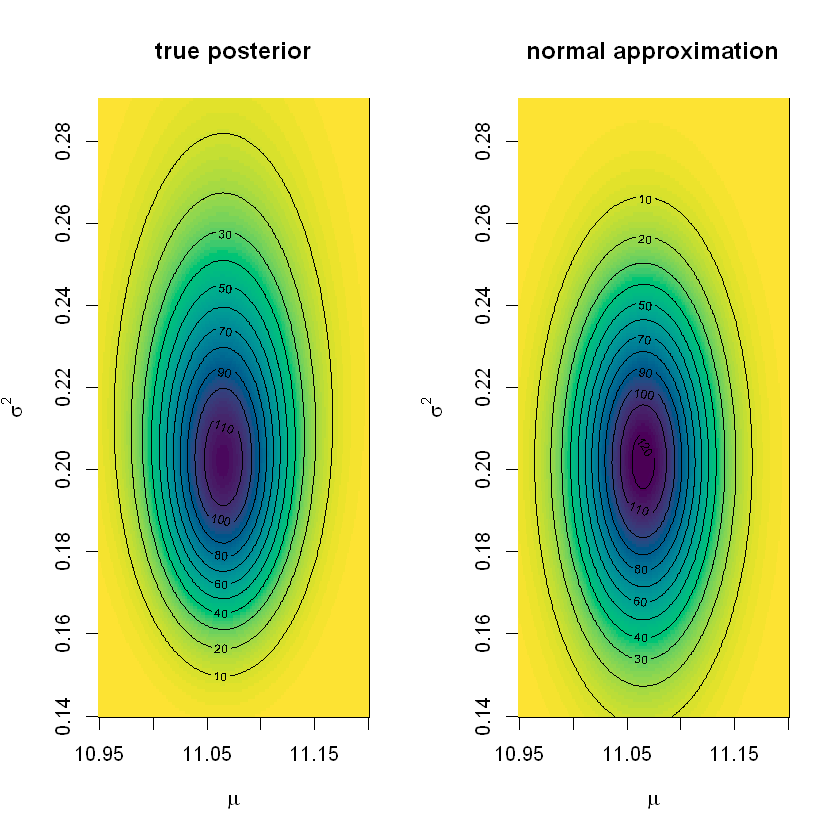

In [47]:
# create sequence of values for mu and sigmasq
mymu <- seq(10.95, 11.2, length = 200)
mysigmasq <- seq(0.14, 0.29, length = 200)
# create grid
mytheta <- expand.grid(mymu, mysigmasq)

# for each row of mytheta, plug it into dpost function
z <- apply(mytheta, 1, function(theta) {
  dpost(theta, y = y, const = const)
})

# convert z to matrix for plotting
zmat <- matrix(z, nrow = length(mymu))

# compute observed Information outside of loop
vhat <- inv_ihat(map$par, length(y))
zhat <- mvtnorm::dmvnorm(
  x = mytheta,
  mean = map$par,
  sigma = vhat
)
# convert z to matrix for plotting
zhatmat <- matrix(zhat, nrow = length(mymu))

# side-by-side results
par(mfrow = c(1, 2))

# create heat map of objective surface
image(mymu, mysigmasq, zmat,
  col = hcl.colors(64, rev = TRUE),
  xlab = expression(mu),
  ylab = expression(sigma^2),
  zlim = range(c(z, zhat))
)
# add contours
contour(mymu, mysigmasq, zmat,
  add = TRUE
)
title("true posterior")

# create heat map of approximation surface
image(mymu, mysigmasq, zhatmat,
  col = hcl.colors(64, rev = TRUE),
  xlab = expression(mu),
  ylab = expression(sigma^2),
  zlim = c(range(c(z, zhat)))
)
# add contours
contour(mymu, mysigmasq, zhatmat, add = TRUE)
title("normal approximation")
par(mfrow = c(1, 1))